## Seldon Model Zoo

Examples of various model artefact types from various frameworks.


### SKLearn Iris Classification Model

In [2]:
!cat ./models/sklearn-iris-gs.yaml

apiVersion: mlops.seldon.io/v1alpha1
kind: Model
metadata:
  name: iris
spec:
  storageUri: "gs://seldon-models/scv2/samples/mlserver_1.2.3/iris-sklearn"
  requirements:
  - sklearn
  memory: 100Ki


Load the model

In [3]:
!seldon model load -f ./models/sklearn-iris-gs.yaml

{}


In [4]:
!seldon model status iris -w ModelAvailable | jq -M .

{}


In [5]:
!seldon model infer iris \
  '{"inputs": [{"name": "predict", "shape": [1, 4], "datatype": "FP32", "data": [[1, 2, 3, 4]]}]}' 

{
	"model_name": "iris_1",
	"model_version": "1",
	"id": "fa880d0d-2262-42bf-b5b1-f083b891fb81",
	"parameters": {},
	"outputs": [
		{
			"name": "predict",
			"shape": [
				1,
				1
			],
			"datatype": "INT64",
			"data": [
				2
			]
		}
	]
}


In [6]:
!seldon model unload iris

{}


### Tensorflow CIFAR10 Image Classification Model


In [7]:
import requests
import json
from typing import Dict, List
import numpy as np
import os
import tensorflow as tf
from alibi_detect.utils.perturbation import apply_mask
from alibi_detect.datasets import fetch_cifar10c
import matplotlib.pyplot as plt
tf.keras.backend.clear_session()

2023-01-27 18:51:43.394466: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-27 18:51:43.394480: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [8]:
train, test = tf.keras.datasets.cifar10.load_data()
X_train, y_train = train
X_test, y_test = test

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)


(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


In [9]:
outliers = []
for idx in range(0,X_train.shape[0]):
    X_mask, mask = apply_mask(X_train[idx].reshape(1, 32, 32, 3),
                                  mask_size=(12,12),
                                  n_masks=1,
                                  channels=[0,1,2],
                                  mask_type='normal',
                                  noise_distr=(0,1),
                                  clip_rng=(0,1))
    outliers.append(X_mask)
X_outliers = np.vstack(outliers)
X_outliers.shape
corruption = ['gaussian_noise']
X_corr, y_corr = fetch_cifar10c(corruption=corruption, severity=5, return_X_y=True)
X_corr = X_corr.astype('float32') / 255

In [25]:
reqJson = json.loads('{"inputs":[{"name":"input_1","data":[],"datatype":"FP32","shape":[]}]}')
url = "http://0.0.0.0:9000/v2/models/model/infer"

def infer(resourceName: str, idx: int, requestType: str):
    if requestType == "outlier":
        rows = X_outliers[idx:idx+1]
    elif requestType == "drift":
        rows = X_corr[idx:idx+1]
    else:
        rows = X_train[idx:idx+1]
    show(rows[0])
    reqJson["inputs"][0]["data"] = rows.flatten().tolist()
    reqJson["inputs"][0]["shape"] = [1, 32, 32, 3]
    headers = {"Content-Type": "application/json", "seldon-model":resourceName}
    response_raw = requests.post(url, json=reqJson, headers=headers)
    probs = np.array(response_raw.json()["outputs"][0]["data"])
    print(classes[probs.argmax(axis=0)])
    

def show(X):
    plt.imshow(X.reshape(32, 32, 3))
    plt.axis("off")
    plt.show()


In [11]:
!cat ./models/cifar10-no-config.yaml

apiVersion: mlops.seldon.io/v1alpha1
kind: Model
metadata:
  name: cifar10
spec:
  storageUri: "gs://seldon-models/scv2/samples/tensorflow/cifar10"
  requirements:
  - tensorflow


Load the model.

In [12]:
!seldon model load -f ./models/cifar10-no-config.yaml

{}


In [13]:
!seldon model status cifar10 -w ModelAvailable | jq -M .

{}


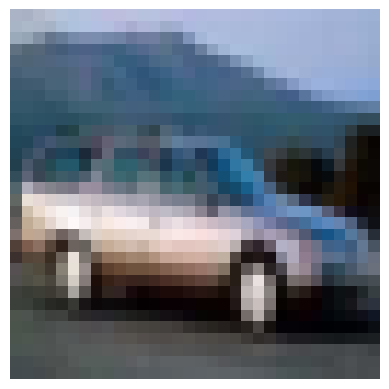

car


In [29]:
infer("cifar10",4, "normal")

In [30]:
!seldon model unload cifar10

{}


### XGBoost Model

In [35]:
!cat ./models/income-xgb.yaml

apiVersion: mlops.seldon.io/v1alpha1
kind: Model
metadata:
  name: income-xgb
spec:
  storageUri: "gs://seldon-models/scv2/samples/mlserver_1.2.3/income-xgb"
  requirements:
  - xgboost


In [36]:
!seldon model load -f ./models/income-xgb.yaml

{}


In [37]:
!seldon model status income-xgb -w ModelAvailable | jq -M .

{}


In [38]:
!seldon model infer income-xgb \
  '{ "parameters": {"content_type": "pd"}, "inputs": [{"name": "Age", "shape": [1, 1], "datatype": "INT64", "data": [47]},{"name": "Workclass", "shape": [1, 1], "datatype": "INT64", "data": [4]},{"name": "Education", "shape": [1, 1], "datatype": "INT64", "data": [1]},{"name": "Marital Status", "shape": [1, 1], "datatype": "INT64", "data": [1]},{"name": "Occupation", "shape": [1, 1], "datatype": "INT64", "data": [1]},{"name": "Relationship", "shape": [1, 1], "datatype": "INT64", "data": [3]},{"name": "Race", "shape": [1, 1], "datatype": "INT64", "data": [4]},{"name": "Sex", "shape": [1, 1], "datatype": "INT64", "data": [1]},{"name": "Capital Gain", "shape": [1, 1], "datatype": "INT64", "data": [0]},{"name": "Capital Loss", "shape": [1, 1], "datatype": "INT64", "data": [0]},{"name": "Hours per week", "shape": [1, 1], "datatype": "INT64", "data": [40]},{"name": "Country", "shape": [1, 1], "datatype": "INT64", "data": [9]}]}' 

{
	"model_name": "income-xgb_1",
	"model_version": "1",
	"id": "bc128d69-6156-4df7-9ba6-dbbf6ea5bc3c",
	"parameters": {},
	"outputs": [
		{
			"name": "predict",
			"shape": [
				1,
				1
			],
			"datatype": "FP32",
			"data": [
				-1.8380107879638672
			]
		}
	]
}


In [39]:
!seldon model unload income-xgb

{}


## ONNX Model

In [40]:
import matplotlib.pyplot as plt
import json
import requests
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision import transforms
from torch.utils.data import DataLoader
training_data = MNIST(
    root=".",
    download=True,
    train=False,
    transform = transforms.Compose([
              transforms.ToTensor()
          ])
)


/home/clive/miniconda3/envs/scv2/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [46]:
reqJson = json.loads('{"inputs":[{"name":"Input3","data":[],"datatype":"FP32","shape":[]}]}')
url = "http://0.0.0.0:9000/v2/models/model/infer"
dl = DataLoader(training_data, batch_size=1, shuffle=False)
dlIter = iter(dl)

def infer_mnist():
    x, y = next(dlIter)
    data = x.cpu().numpy()
    reqJson["inputs"][0]["data"] = data.flatten().tolist()
    reqJson["inputs"][0]["shape"] = [1, 1, 28, 28]
    headers = {"Content-Type": "application/json", "seldon-model":"mnist"}
    response_raw = requests.post(url, json=reqJson, headers=headers)
    show_mnist(x)
    probs = np.array(response_raw.json()["outputs"][0]["data"])
    print(probs.argmax(axis=0))
    

def show_mnist(X):
    plt.imshow(X.reshape(28, 28))
    plt.axis("off")
    plt.show()

In [42]:
!cat ./models/mnist.yaml

apiVersion: mlops.seldon.io/v1alpha1
kind: Model
metadata:
  name: mnist
spec:
  storageUri: "gs://seldon-models/scv2/samples/mlserver_1.2.3/mnist-onnx"
  requirements:
  - onnx


In [43]:
!seldon model load -f ./models/mnist.yaml

{}


In [44]:
!seldon model status mnist -w ModelAvailable | jq -M .

{}


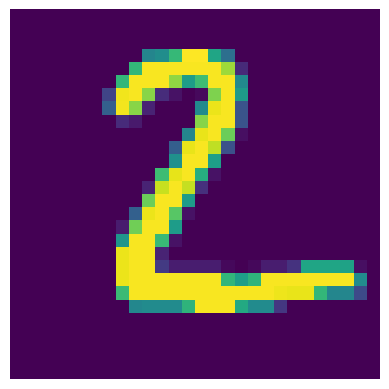

2


In [48]:
infer_mnist()

### LightGBM Model

In [58]:
!cat ./models/income-lgb.yaml

apiVersion: mlops.seldon.io/v1alpha1
kind: Model
metadata:
  name: income-lgb
spec:
  storageUri: "gs://seldon-models/scv2/samples/mlserver_1.2.3/income-lgb"
  requirements:
  - lightgbm


In [59]:
!seldon model load -f ./models/income-lgb.yaml

{}


In [60]:
!seldon model status income-lgb -w ModelAvailable | jq -M .

{}


In [52]:
!seldon model infer income-lgb \
  '{ "parameters": {"content_type": "pd"}, "inputs": [{"name": "Age", "shape": [1, 1], "datatype": "INT64", "data": [47]},{"name": "Workclass", "shape": [1, 1], "datatype": "INT64", "data": [4]},{"name": "Education", "shape": [1, 1], "datatype": "INT64", "data": [1]},{"name": "Marital Status", "shape": [1, 1], "datatype": "INT64", "data": [1]},{"name": "Occupation", "shape": [1, 1], "datatype": "INT64", "data": [1]},{"name": "Relationship", "shape": [1, 1], "datatype": "INT64", "data": [3]},{"name": "Race", "shape": [1, 1], "datatype": "INT64", "data": [4]},{"name": "Sex", "shape": [1, 1], "datatype": "INT64", "data": [1]},{"name": "Capital Gain", "shape": [1, 1], "datatype": "INT64", "data": [0]},{"name": "Capital Loss", "shape": [1, 1], "datatype": "INT64", "data": [0]},{"name": "Hours per week", "shape": [1, 1], "datatype": "INT64", "data": [40]},{"name": "Country", "shape": [1, 1], "datatype": "INT64", "data": [9]}]}' 

{
	"model_name": "income-lgb_1",
	"model_version": "1",
	"id": "4dde5b4e-a6c8-411e-a53d-0d67279b241d",
	"parameters": {},
	"outputs": [
		{
			"name": "predict",
			"shape": [
				1,
				1
			],
			"datatype": "FP64",
			"data": [
				0.06279460120044741
			]
		}
	]
}


In [53]:
!seldon model unload income-lgb

{}


### MLFlow Wine Model

In [61]:
!cat ./models/wine-mlflow.yaml

apiVersion: mlops.seldon.io/v1alpha1
kind: Model
metadata:
  name: wine
spec:
  storageUri: "gs://seldon-models/scv2/samples/mlserver_1.2.3/wine-mlflow"
  requirements:
  - mlflow


In [62]:
!seldon model load -f ./models/wine-mlflow.yaml

{}


In [63]:
!seldon model status wine -w ModelAvailable | jq -M .

{}


In [66]:
import requests
url = "http://0.0.0.0:9000/v2/models/model/infer"
inference_request = {
    "inputs": [
        {
          "name": "fixed acidity",
          "shape": [1],
          "datatype": "FP32",
          "data": [7.4],
        },
        {
          "name": "volatile acidity",
          "shape": [1],
          "datatype": "FP32",
          "data": [0.7000],
        },
        {
          "name": "citric acid",
          "shape": [1],
          "datatype": "FP32",
          "data": [0],
        },
        {
          "name": "residual sugar",
          "shape": [1],
          "datatype": "FP32",
          "data": [1.9],
        },
        {
          "name": "chlorides",
          "shape": [1],
          "datatype": "FP32",
          "data": [0.076],
        },
        {
          "name": "free sulfur dioxide",
          "shape": [1],
          "datatype": "FP32",
          "data": [11],
        },
        {
          "name": "total sulfur dioxide",
          "shape": [1],
          "datatype": "FP32",
          "data": [34],
        },
        {
          "name": "density",
          "shape": [1],
          "datatype": "FP32",
          "data": [0.9978],
        },
        {
          "name": "pH",
          "shape": [1],
          "datatype": "FP32",
          "data": [3.51],
        },
        {
          "name": "sulphates",
          "shape": [1],
          "datatype": "FP32",
          "data": [0.56],
        },
        {
          "name": "alcohol",
          "shape": [1],
          "datatype": "FP32",
          "data": [9.4],
        },
    ]
}
headers = {"Content-Type": "application/json", "seldon-model":"wine"}
response_raw = requests.post(url, json=inference_request, headers=headers)
print(response_raw.json())

{'model_name': 'wine_1', 'model_version': '1', 'id': '0d5570ac-539e-4846-b945-ac5742e781f8', 'parameters': {}, 'outputs': [{'name': 'output-1', 'shape': [1, 1], 'datatype': 'FP64', 'data': [5.576883936610762]}]}


In [67]:
!seldon model unload wine

{}
